In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import os

%matplotlib inline

## 探索数据集

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

In [3]:
df_train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test.head(1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_test.values.max()

255

In [6]:
df_train.iloc[:, 0].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

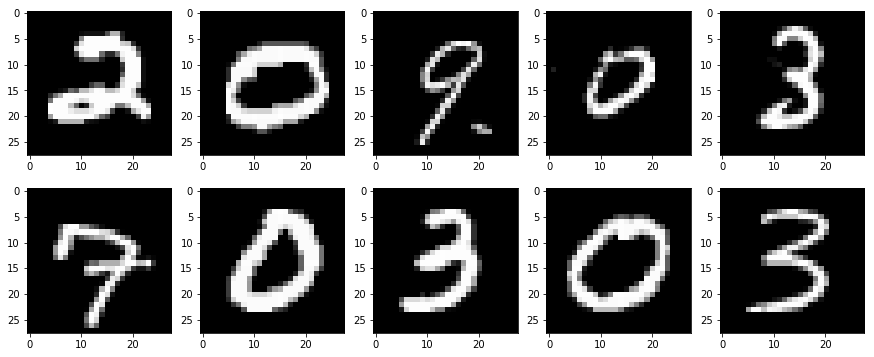

In [7]:
example_imgs = df_test.iloc[:10].values.reshape(-1, 28, 28)

plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['image.cmap'] = 'gray'
for index, img in enumerate(example_imgs):
    plt.subplot(2, 5, index+1)
    plt.imshow(img)

## 划分数据集

In [8]:
X_total = df_train.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
Y_total = df_train.iloc[:, 0].values.reshape(-1, 1)
X_test = df_test.values.reshape(-1, 28, 28, 1)

X_total.shape, Y_total.shape, X_test.shape

((42000, 28, 28, 1), (42000, 1), (28000, 28, 28, 1))

In [9]:
shuffle_indexs = np.random.permutation(X_total.shape[0])
X_total_shuffle = X_total[shuffle_indexs]
Y_total_shuffle = Y_total[shuffle_indexs]

In [10]:
dev_size = 6000

X_dev = X_total_shuffle[:dev_size]
Y_dev = Y_total_shuffle[:dev_size]
X_train = X_total_shuffle[dev_size:]
Y_train = Y_total_shuffle[dev_size:]

## 数据生成器

#### 数据增强

In [11]:
def data_augmentation(X, Y=None):
    if Y is None:
        return X
    else:
        return X, Y

#### 数据归一化

In [12]:
def normalize_data(X, Y=None):
    if Y is None:
        return X / 255
    else:
        return X / 255, Y

#### mini batch 生成器

In [140]:
def batch_gen(X, Y, batch_size, repeat=1, num_parallels=4, augmentation=False):
    m = X.shape[0]
    steps_per_epoch = np.ceil(m / batch_size)
    
    if Y is None:
        dataset = tf.data.Dataset.from_tensor_slices(X)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, Y))
        
    if augmentation:
        dataset = dataset.map(data_augmentation, num_parallels)
        
    dataset = dataset.map(normalize_data, num_parallels)
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.repeat(repeat)
    
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next(), steps_per_epoch

## 构建神经网络

In [141]:
def build_placeholder():
    with tf.name_scope('input_placeholder'):
        X = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1), name='input_X')
        Y = tf.placeholder(dtype=tf.int32, shape=(None, 1), name='lable_Y')
        training = tf.placeholder(dtype=tf.bool, name='training')
    
    return X, Y, training

In [142]:
def build_conv_layer(inputs, training, keep_prob, filters, kernel_size, strides, name):
    with tf.name_scope('conv_layer_' + name):
        Z = tf.layers.conv2d(inputs, filters=filters, kernel_size=kernel_size, strides=strides, 
                             padding='same', use_bias=False, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        Z_batch_norm = tf.layers.batch_normalization(inputs, training=training)
        
        A = tf.nn.relu(Z_batch_norm)
        
        A_dropout = tf.nn.dropout(A, keep_prob)
        
    return A_dropout

In [143]:
def build_max_pool(inputs, pool_size, strides, name):
    with tf.name_scope('max_pool_' + name):
        pool = tf.layers.max_pooling2d(inputs, pool_size, strides, name='max_pool')
        
    return pool

In [144]:
def build_flatten_layer(inputs):
    with tf.name_scope('flatten_layer'):
        flatten = tf.layers.flatten(inputs)
        
    return flatten

In [145]:
def build_softmax_layer(inputs):
    with tf.name_scope('softmax_layer'):
        Z = tf.layers.dense(inputs, 10, kernel_initializer=tf.contrib.layers.xavier_initializer())
        A = tf.nn.softmax(Z)
        
    return Z, A

In [146]:
def build_cost(logits, labels):
    with tf.name_scope('cost'):
        labels_onehot = tf.one_hot(labels, 10, axis=-1)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_onehot, logits=logits))
    
    return cost

In [147]:
def build_accuracy(outputs, labels):
    with tf.name_scope('accuracy'):
        predicts = tf.argmax(outputs, axis=-1, output_type=tf.int32)
        is_rights = tf.equal(predicts, tf.reshape(labels, (-1,)))
        accuracy = tf.reduce_mean(tf.cast(is_rights, tf.float32))
    
    return accuracy

In [148]:
def build_foreward(X, Y, training, keep_prob):    
    conv1 = build_conv_layer(X, training, keep_prob, 8, (3, 3), (1, 1), '1')
    conv2 = build_conv_layer(conv1, training, keep_prob, 8, (3, 3), (1, 1), '2')
    max_pool2 = build_max_pool(conv2, (2, 2), (2, 2), '2')
    
    conv3 = build_conv_layer(max_pool2, training, keep_prob, 16, (3, 3), (1, 1), '3')
    conv4 = build_conv_layer(conv3, training, keep_prob, 16, (3, 3), (1, 1), '4')
    
    flatten = build_flatten_layer(conv3)
    
    logits, outputs = build_softmax_layer(flatten)
    
    return logits, outputs

In [149]:
CKPT_PATH = './model_save/model.ckpt'
COSTS_PATH = './model_save/costs_save.npy'
ACCS_PATH = './model_save/accs_save.npy'
STEPS_PATH = './model_save/step_save.npy'

#### 训练

In [150]:
def train(lr, keep_prob, batch_size, epochs, print_step, metrics_step, resume=True):
    tf.reset_default_graph()
    
    X_pl, Y_pl, training_pl = build_placeholder()
    logits_op, outputs_op = build_foreward(X_pl, Y_pl, training_pl, keep_prob)
    cost_op = build_cost(logits_op, Y_pl)
    accuracy_op = build_accuracy(outputs_op, Y_pl)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer_op = tf.train.AdamOptimizer(lr).minimize(cost_op)
    
    train_next_op, train_steps_per_epoch = batch_gen(X_train, Y_train, batch_size, epochs, augmentation=True)
    dev_next_op, _ = batch_gen(X_dev, Y_dev, batch_size, epochs)
    
    sess = tf.Session()
    
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    step = 1
    cost_list = []
    acc_list = []
    
    saver = tf.train.Saver()
    if resume:
        saver.restore(sess, CKPT_PATH)
        cost_list = list(np.load(COSTS_PATH))
        acc_list = list(np.load(ACCS_PATH))
        step = np.load(STEPS_PATH)
        epoch = int(np.ceil(step / train_steps_per_epoch)) + 1
    
    try:
        while True:
            train_X_batch, train_Y_batch = sess.run(train_next_op)

            _, cost, train_batch_accuracy = sess.run((optimizer_op, cost_op, accuracy_op), feed_dict={
                X_pl: train_X_batch,
                Y_pl: train_Y_batch,
                training_pl: True
            })
            
            if step % print_step == 0:
                print('epoch:{0} - step:{1} - cost:{2:.4f} - accuracy:%{3:.2f}'.format(
                    epoch, step, cost, train_batch_accuracy * 100))
                
            if step % metrics_step == 0:
                cost_list.append(cost)
                acc_list.append(train_batch_accuracy)
            
            step += 1
            if step % train_steps_per_epoch == 0:
                epoch += 1
    except tf.errors.OutOfRangeError:
        pass

    saver.save(sess, CKPT_PATH)
    np.save(COSTS_PATH, cost_list)
    np.save(ACCS_PATH, acc_list)
    np.save(STEPS_PATH, step - 1)
    
    sess.close()
    
    return cost_list, acc_list

#### 参数

In [151]:
LR = 0.0001
KEEP_PROB = 1
BATCH_SIZE = 16
EPOCHS = 5
PRINT_STEP = 500
METRICS_STEP = 100
RESUME = False

In [152]:
costs, accs = train(lr=LR, keep_prob=KEEP_PROB, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, print_step=PRINT_STEP, metrics_step=METRICS_STEP, resume=RESUME)

epoch:1 - step:500 - cost:1.8878 - accuracy:%31.25
epoch:1 - step:1000 - cost:1.3838 - accuracy:%68.75
epoch:1 - step:1500 - cost:1.0760 - accuracy:%62.50
epoch:1 - step:2000 - cost:0.7594 - accuracy:%62.50
epoch:2 - step:2500 - cost:0.4875 - accuracy:%100.00
epoch:2 - step:3000 - cost:0.6642 - accuracy:%87.50
epoch:2 - step:3500 - cost:0.6023 - accuracy:%75.00
epoch:2 - step:4000 - cost:0.7894 - accuracy:%68.75
epoch:3 - step:4500 - cost:0.3951 - accuracy:%93.75
epoch:3 - step:5000 - cost:0.3124 - accuracy:%87.50
epoch:3 - step:5500 - cost:0.4196 - accuracy:%81.25
epoch:3 - step:6000 - cost:0.2200 - accuracy:%93.75
epoch:3 - step:6500 - cost:1.0009 - accuracy:%75.00
epoch:4 - step:7000 - cost:0.5644 - accuracy:%81.25
epoch:4 - step:7500 - cost:0.6050 - accuracy:%75.00
epoch:4 - step:8000 - cost:0.6510 - accuracy:%81.25
epoch:4 - step:8500 - cost:0.3250 - accuracy:%93.75
epoch:5 - step:9000 - cost:0.5096 - accuracy:%87.50
epoch:5 - step:9500 - cost:0.2241 - accuracy:%93.75
epoch:5 - st

#### 训练曲线

In [153]:
def plot(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

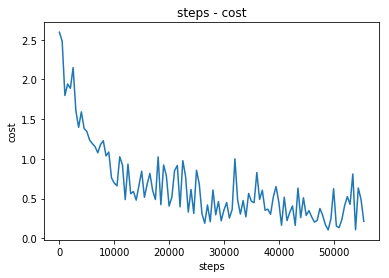

In [154]:
x_plot = list(range(1, (len(costs)) * PRINT_STEP, PRINT_STEP))
plot(x_plot, costs, 'steps', 'cost', 'steps - cost')

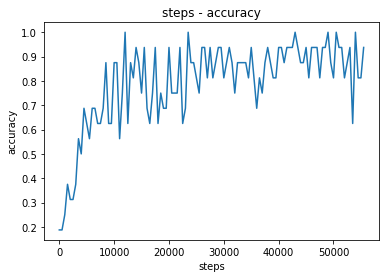

In [155]:
plot(x_plot, accs, 'steps', 'accuracy', 'steps - accuracy')

#### 在验证集上评估训练结果

In [156]:
def evaluate(batch_size=16):
    tf.reset_default_graph()
    
    X_pl, Y_pl, training_pl = build_placeholder()
    logits_op, outputs_op = build_foreward(X_pl, Y_pl, training_pl, 1)
    accuracy_op = build_accuracy(outputs_op, Y_pl)
    
    train_next_op, _ = batch_gen(X_train, Y_train, batch_size, 1)
    dev_next_op, _ = batch_gen(X_dev, Y_dev, batch_size, 1)
    
    sess = tf.Session()
    
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, CKPT_PATH)
    
    train_acc_list = []
    dev_acc_list = []
    
    try:
        while True:
            train_X_batch, train_Y_batch = sess.run(train_next_op)

            train_batch_accuracy = sess.run(accuracy_op, feed_dict={
                X_pl: train_X_batch,
                Y_pl: train_Y_batch,
                training_pl: False
            })
            
            train_acc_list.append(train_batch_accuracy)
    except tf.errors.OutOfRangeError:
        pass
    
    try:
        while True:
            dev_X_batch, dev_Y_batch = sess.run(dev_next_op)

            dev_batch_accuracy = sess.run(accuracy_op, feed_dict={
                X_pl: dev_X_batch,
                Y_pl: dev_Y_batch,
                training_pl: False
            })
            
            dev_acc_list.append(dev_batch_accuracy)
    except tf.errors.OutOfRangeError:
        pass
    
    train_acc = np.mean(train_acc_list)
    dev_acc = np.mean(dev_acc_list)
    
    print('train_accuracy: %{:.2f}'.format(train_acc * 100))
    print('dev_accuracy: %{:.2f}'.format(dev_acc * 100))
    
    sess.close()

In [157]:
evaluate()

INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt
train_accuracy: %89.07
dev_accuracy: %88.63


#### 预测

In [158]:
def predict(X, batch_size=16):
    tf.reset_default_graph()
    
    X_pl, Y_pl, training_pl = build_placeholder()
    _, outputs_op = build_foreward(X_pl, Y_pl, training_pl, 1)
    
    next_op, _ = batch_gen(X, None, batch_size, 1)
    
    sess = tf.Session()
    
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, CKPT_PATH)
    
    output_list = []
    
    try:
        while True:
            X_batch = sess.run(next_op)

            output_batch = sess.run(outputs_op, feed_dict={
                X_pl: X_batch,
                training_pl: False
            })
            
            output_list.append(np.argmax(output_batch, axis=-1))
    except tf.errors.OutOfRangeError:
        pass
    
    sess.close()
    
    return np.concatenate(output_list, axis=0)

In [159]:
predictions = predict(X_test)
predictions.shape

INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt


(28000,)

#### 预测结果写入csv文件

In [160]:
PREDICTIONS_PATH = './test.csv'

In [161]:
def save_predictions_to_csv(predictions, save_path):
    df = pd.DataFrame({
        'ImageId': np.arange(1, predictions.shape[0] + 1),
        'Label': predictions,
    })
    
    df.to_csv(save_path, index=False)
    
    return df

In [162]:
pre_df = save_predictions_to_csv(preditions, PREDICTIONS_PATH)
pre_df.head(3)

,ImageId,Label
0,1,5
1,2,2
2,3,7
